Epoch [1/100], Loss: 4.1238
Epoch [2/100], Loss: 3.6302
Epoch [3/100], Loss: 3.3986
Epoch [4/100], Loss: 3.1169
Epoch [5/100], Loss: 3.0689
Epoch [6/100], Loss: 3.0300
Epoch [7/100], Loss: 3.0199
Epoch [8/100], Loss: 3.0139
Epoch [9/100], Loss: 3.0008
Epoch [10/100], Loss: 3.0000
Epoch [11/100], Loss: 2.9914
Epoch [12/100], Loss: 2.9935
Epoch [13/100], Loss: 2.9915
Epoch [14/100], Loss: 2.9820
Epoch [15/100], Loss: 2.9856
Epoch [16/100], Loss: 2.9798
Epoch [17/100], Loss: 2.9757
Epoch [18/100], Loss: 2.9767
Epoch [19/100], Loss: 2.9717
Epoch [20/100], Loss: 2.9664
Epoch [21/100], Loss: 2.9663
Epoch [22/100], Loss: 2.9663
Epoch [23/100], Loss: 2.9680
Epoch [24/100], Loss: 2.9617
Epoch [25/100], Loss: 2.9602
Epoch [26/100], Loss: 2.9687
Epoch [27/100], Loss: 2.9580
Epoch [28/100], Loss: 2.9600
Epoch [29/100], Loss: 2.9621
Epoch [30/100], Loss: 2.9586
Epoch [31/100], Loss: 2.9597
Epoch [32/100], Loss: 2.9550
Epoch [33/100], Loss: 2.9536
Epoch [34/100], Loss: 2.9587
Epoch [35/100], Loss: 2

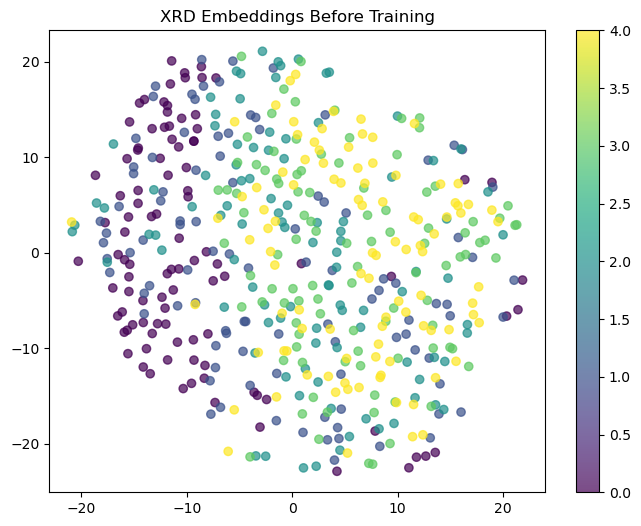

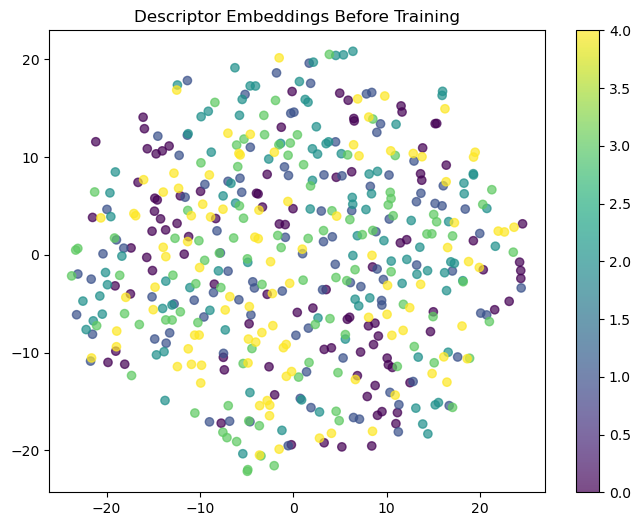

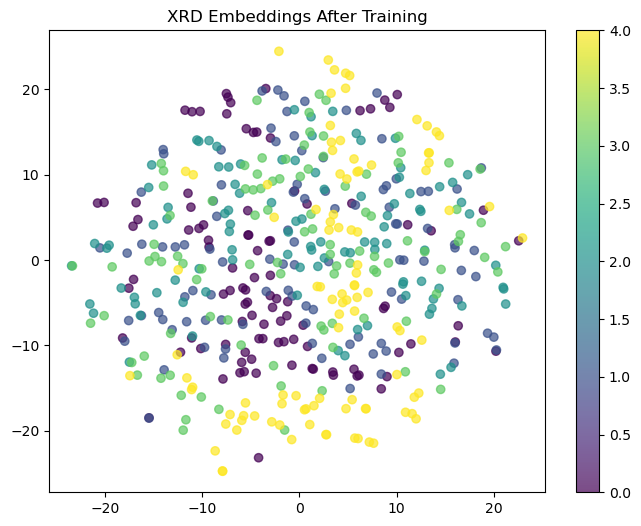

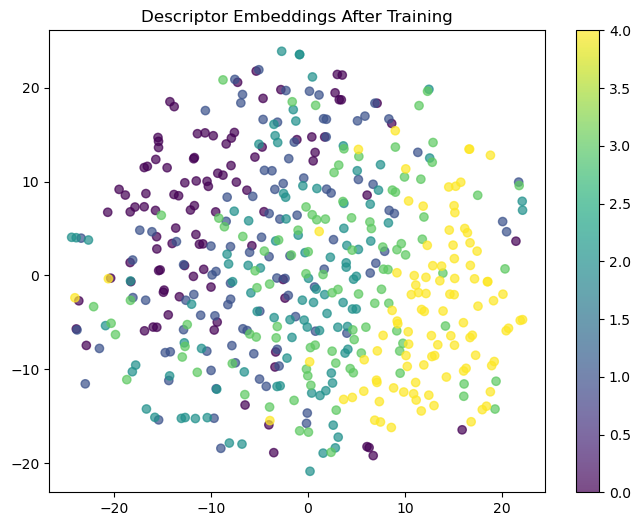

In [8]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Generate synthetic data
num_samples = 500
xrd_dim = 100
descriptor_dim = 50
spacegroup_dim = 10
composition_dim = 15

np.random.seed(42)
XRD_data = np.random.rand(num_samples, xrd_dim)
threeD_descriptors = np.random.rand(num_samples, descriptor_dim)
spacegroup_data = np.random.randint(0, 2, size=(num_samples, spacegroup_dim))
composition_data = np.random.randint(0, 3, size=(num_samples, composition_dim))

# Introduce clusters
for i in range(5):
    XRD_data[i*100:(i+1)*100] += i * 0.5
    threeD_descriptors[i*100:(i+1)*100] += i * 0.5

# Normalize data
from sklearn.preprocessing import StandardScaler

scaler_xrd = StandardScaler()
XRD_data = scaler_xrd.fit_transform(XRD_data)

scaler_desc = StandardScaler()
threeD_descriptors = scaler_desc.fit_transform(threeD_descriptors)

# Dataset and DataLoader
class CrystalDataset(Dataset):
    def __init__(self, XRD_data, descriptors, spacegroup=None, composition=None):
        self.XRD_data = torch.tensor(XRD_data, dtype=torch.float32)
        self.descriptors = torch.tensor(descriptors, dtype=torch.float32)
        self.spacegroup = torch.tensor(spacegroup, dtype=torch.float32) if spacegroup is not None else None
        self.composition = torch.tensor(composition, dtype=torch.float32) if composition is not None else None

    def __len__(self):
        return len(self.XRD_data)

    def __getitem__(self, idx):
        sample = {
            'XRD': self.XRD_data[idx],
            'descriptor': self.descriptors[idx]
        }
        if self.spacegroup is not None:
            sample['spacegroup'] = self.spacegroup[idx]
        if self.composition is not None:
            sample['composition'] = self.composition[idx]
        return sample

dataset = CrystalDataset(XRD_data, threeD_descriptors, spacegroup_data, composition_data)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Model definitions
class XRDEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(XRDEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim)
        )

    def forward(self, x):
        return self.encoder(x)

class DescriptorEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(DescriptorEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim)
        )

    def forward(self, x):
        return self.encoder(x)

class SpacegroupEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(SpacegroupEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, embedding_dim)
        )

    def forward(self, x):
        return self.encoder(x)

class CompositionEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(CompositionEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, embedding_dim)
        )

    def forward(self, x):
        return self.encoder(x)

# Initialize models
xrd_input_dim = xrd_dim
descriptor_input_dim = descriptor_dim
embedding_dim = 2

xrd_encoder = XRDEncoder(xrd_input_dim, embedding_dim)
descriptor_encoder = DescriptorEncoder(descriptor_input_dim, embedding_dim)

spacegroup_input_dim = spacegroup_dim
composition_input_dim = composition_dim
additional_embedding_dim = 16

spacegroup_encoder = SpacegroupEncoder(spacegroup_input_dim, additional_embedding_dim)
composition_encoder = CompositionEncoder(composition_input_dim, additional_embedding_dim)

def nt_xent_loss(z_i, z_j, temperature=0.5):
    batch_size = z_i.size(0)
    device = z_i.device

    # Normalize embeddings
    z_i = F.normalize(z_i, dim=1)
    z_j = F.normalize(z_j, dim=1)

    # Concatenate embeddings
    z = torch.cat([z_i, z_j], dim=0)  # [2N, D]

    # Compute similarity matrix
    sim_matrix = torch.matmul(z, z.T)  # [2N, 2N]
    sim_matrix = sim_matrix / temperature

    # Remove self-similarities from the matrix
    mask = torch.eye(2 * batch_size, dtype=torch.bool).to(device)
    sim_matrix = sim_matrix.masked_fill(mask, -float('inf'))

    # Positive samples: Off-diagonal elements corresponding to positive pairs
    positives = torch.cat([torch.arange(batch_size, 2 * batch_size), torch.arange(0, batch_size)]).to(device)

    # Labels for cross-entropy
    labels = positives

    # Compute loss
    loss = F.cross_entropy(sim_matrix, labels)

    return loss

# Optimizer and device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

xrd_encoder.to(device)
descriptor_encoder.to(device)
spacegroup_encoder.to(device)
composition_encoder.to(device)

optimizer = optim.Adam(
    list(xrd_encoder.parameters()) + 
    list(descriptor_encoder.parameters()) +
    list(spacegroup_encoder.parameters()) +
    list(composition_encoder.parameters()),
    lr=1e-3
)

# Extract embeddings before training
xrd_encoder.eval()
descriptor_encoder.eval()
spacegroup_encoder.eval()
composition_encoder.eval()

with torch.no_grad():
    xrd_embeddings_before = xrd_encoder(torch.tensor(XRD_data, dtype=torch.float32).to(device))
    desc_embeddings_before = descriptor_encoder(torch.tensor(threeD_descriptors, dtype=torch.float32).to(device))

    sg_embeddings = spacegroup_encoder(torch.tensor(spacegroup_data, dtype=torch.float32).to(device))
    comp_embeddings = composition_encoder(torch.tensor(composition_data, dtype=torch.float32).to(device))

    xrd_embeddings_before = torch.cat([xrd_embeddings_before, sg_embeddings, comp_embeddings], dim=1).cpu().numpy()
    desc_embeddings_before = torch.cat([desc_embeddings_before, sg_embeddings, comp_embeddings], dim=1).cpu().numpy()

# Training loop
num_epochs = 100

# Training Loop
for epoch in range(num_epochs):
    xrd_encoder.train()
    descriptor_encoder.train()
    spacegroup_encoder.train()
    composition_encoder.train()
    total_loss = 0

    for batch in dataloader:
        xrd = batch['XRD'].to(device)
        desc = batch['descriptor'].to(device)
        sg = batch['spacegroup'].to(device)
        comp = batch['composition'].to(device)

        optimizer.zero_grad()

        # Forward pass
        z_i = xrd_encoder(xrd)
        z_j = descriptor_encoder(desc)

        # Additional features
        sg_emb = spacegroup_encoder(sg)
        comp_emb = composition_encoder(comp)

        z_i = torch.cat([z_i, sg_emb, comp_emb], dim=1)
        z_j = torch.cat([z_j, sg_emb, comp_emb], dim=1)

        # Compute loss using the corrected nt_xent_loss
        loss = nt_xent_loss(z_i, z_j)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Extract embeddings after training
xrd_encoder.eval()
descriptor_encoder.eval()
spacegroup_encoder.eval()
composition_encoder.eval()

with torch.no_grad():
    xrd_embeddings_after = xrd_encoder(torch.tensor(XRD_data, dtype=torch.float32).to(device))
    desc_embeddings_after = descriptor_encoder(torch.tensor(threeD_descriptors, dtype=torch.float32).to(device))

    sg_embeddings = spacegroup_encoder(torch.tensor(spacegroup_data, dtype=torch.float32).to(device))
    comp_embeddings = composition_encoder(torch.tensor(composition_data, dtype=torch.float32).to(device))

    xrd_embeddings_after = torch.cat([xrd_embeddings_after, sg_embeddings, comp_embeddings], dim=1).cpu().numpy()
    desc_embeddings_after = torch.cat([desc_embeddings_after, sg_embeddings, comp_embeddings], dim=1).cpu().numpy()

# Visualization function remains the same
def plot_embeddings(embeddings, labels, title):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()

# Labels for visualization
labels = np.repeat(np.arange(5), 100)

# Visualize before training
plot_embeddings(xrd_embeddings_before, labels, 'XRD Embeddings Before Training')
plot_embeddings(desc_embeddings_before, labels, 'Descriptor Embeddings Before Training')

# Visualize after training
plot_embeddings(xrd_embeddings_after, labels, 'XRD Embeddings After Training')
plot_embeddings(desc_embeddings_after, labels, 'Descriptor Embeddings After Training')
